In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import Imputer

warnings.filterwarnings(action='ignore', category=FutureWarning)

data = pd.read_csv('input_train.csv')
label = pd.read_csv('challenge_output_data_training_file_prediction_of_transaction_claims_status.csv', ';')
all_data = data.merge(label, left_on='ID', right_on='ID', how='inner').copy()
claim_order = sorted(all_data['CLAIM_TYPE'].unique())

# Fixing Structural Errors

In [2]:
# '3/2017' => 3
temp = all_data['BUYING_DATE'].str.split('/')
all_data['BUYING_DATE'] = temp.str[1] + temp.str[0].str.zfill(2)
all_data['BUYING_DATE'] = all_data['BUYING_DATE'].astype('int32')

# Handle Missing Data

We will put -1 for missing data, the correction will be do later with pipelines to avoid data snooping 

In [3]:
missing_data_columns = all_data.columns[all_data.isna().any()].tolist()
print(missing_data_columns)

['SHIPPING_MODE', 'SHIPPING_PRICE', 'WARRANTIES_PRICE', 'PRICECLUB_STATUS', 'BUYER_BIRTHDAY_DATE', 'SELLER_SCORE_COUNT', 'SELLER_SCORE_AVERAGE']


In [4]:
missing_data = all_data.copy()

# To improve the Unbalanced Dataset we can delete the missing values for CLAIM_TYPE= '-'
missing_data = missing_data.drop(missing_data[(missing_data['CLAIM_TYPE']=='-') & (missing_data['BUYER_BIRTHDAY_DATE'].isna()) ].index)
missing_data = missing_data.drop(missing_data[(missing_data['CLAIM_TYPE']=='-') & (missing_data['SELLER_SCORE_AVERAGE'].isna()) ].index)
missing_data = missing_data.drop(missing_data[(missing_data['CLAIM_TYPE']=='-') & (missing_data['SHIPPING_MODE'].isna()) ].index)
missing_data = missing_data.drop(missing_data[(missing_data['CLAIM_TYPE']=='-') & (missing_data['SHIPPING_PRICE'].isna()) ].index)
missing_data = missing_data.drop(missing_data[(missing_data['CLAIM_TYPE']=='-') & (missing_data['PRICECLUB_STATUS'].isna()) ].index)
missing_data = missing_data.drop(missing_data[(missing_data['CLAIM_TYPE']=='-') & (missing_data['SELLER_SCORE_COUNT'].isna()) ].index)

# Numerical feature 
missing_data['REGISTRATION_DATE'] = missing_data['REGISTRATION_DATE'].fillna(missing_data['REGISTRATION_DATE'].dropna().mean())
missing_data['BUYER_BIRTHDAY_DATE'] = missing_data['BUYER_BIRTHDAY_DATE'].fillna(missing_data['BUYER_BIRTHDAY_DATE'].dropna().mean())
missing_data['BUYING_DATE'] = missing_data['BUYING_DATE'].fillna(missing_data['BUYING_DATE'].dropna().mean())
missing_data['SELLER_SCORE_AVERAGE'] = missing_data['SELLER_SCORE_AVERAGE'].fillna(missing_data['SELLER_SCORE_AVERAGE'].dropna().mean())

# WARRANTIES_PRICE: There is not missing value but NON_WARRANTIES
missing_data['WARRANTIES_PRICE']=missing_data['WARRANTIES_PRICE'].fillna('NON_WARRANTIES').values 

# Categorical Features
missing_data = missing_data.fillna('MISSING')

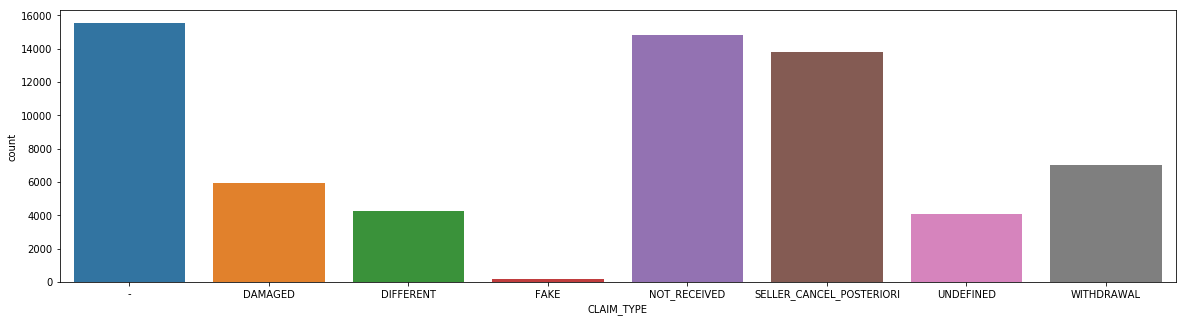

In [5]:
# Dataset after handling missing data
plt.figure(figsize=(20,5))
sns.countplot(missing_data['CLAIM_TYPE'], order=claim_order);

In [6]:
# Numerical missing values SELLER_SCORE_AVERAGE and BUYER_BIRTHDAY_DATE are tagged with -1 for the moment
missing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65549 entries, 0 to 99998
Data columns (total 23 columns):
ID                      65549 non-null int64
SHIPPING_MODE           65549 non-null object
SHIPPING_PRICE          65549 non-null object
WARRANTIES_FLG          65549 non-null bool
WARRANTIES_PRICE        65549 non-null object
CARD_PAYMENT            65549 non-null int64
COUPON_PAYMENT          65549 non-null int64
RSP_PAYMENT             65549 non-null int64
WALLET_PAYMENT          65549 non-null int64
PRICECLUB_STATUS        65549 non-null object
REGISTRATION_DATE       65549 non-null int64
PURCHASE_COUNT          65549 non-null object
BUYER_BIRTHDAY_DATE     65549 non-null float64
BUYER_DEPARTMENT        65549 non-null int64
BUYING_DATE             65549 non-null int32
SELLER_SCORE_COUNT      65549 non-null object
SELLER_SCORE_AVERAGE    65549 non-null float64
SELLER_COUNTRY          65549 non-null object
SELLER_DEPARTMENT       65549 non-null int64
PRODUCT_TYPE            65

# Filter Unwanted Outliers

BUYER_BIRTHDAY_DATE
 - Outliers at the top and bottom

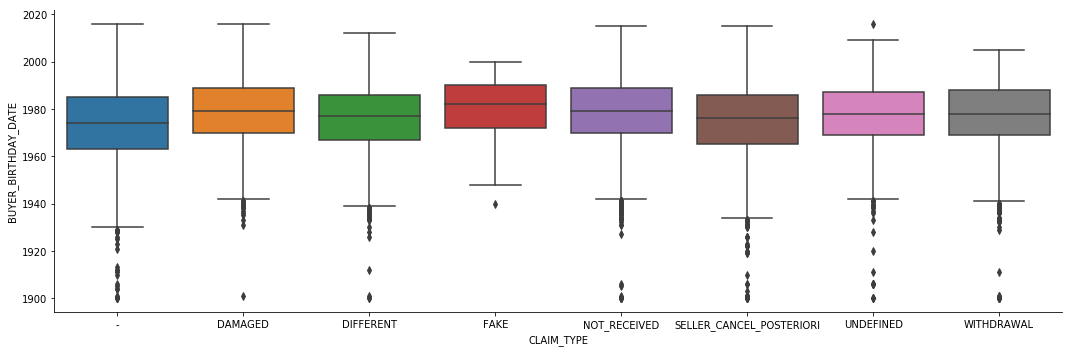

In [7]:
g = sns.catplot(data=missing_data, y='BUYER_BIRTHDAY_DATE', x='CLAIM_TYPE', order=claim_order, kind="box", height=5, aspect=3);

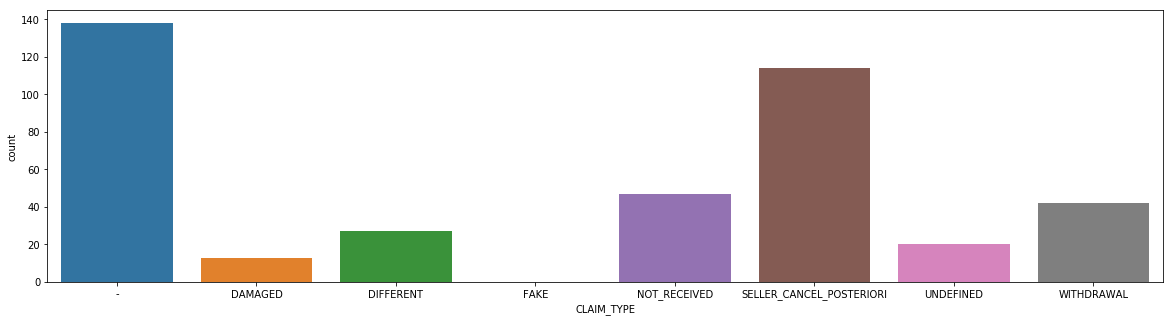

In [8]:
d1=missing_data[(missing_data['BUYER_BIRTHDAY_DATE']<1940)].copy()

plt.figure(figsize=(20,5))
sns.countplot(d1['CLAIM_TYPE'], order=claim_order);

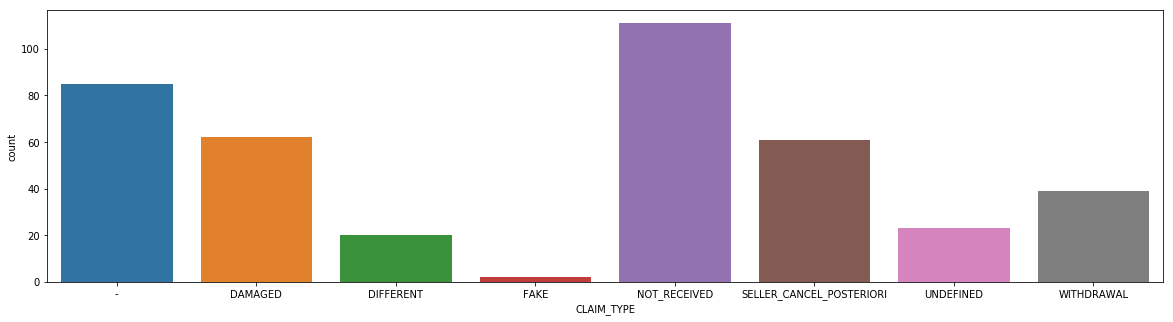

In [9]:
d1=missing_data[(missing_data['BUYER_BIRTHDAY_DATE']>=2000)].copy()

plt.figure(figsize=(20,5))
sns.countplot(d1['CLAIM_TYPE'], order=claim_order);

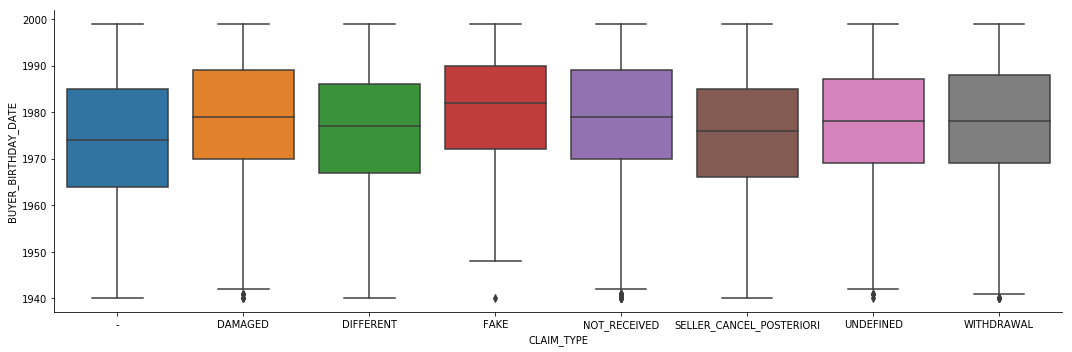

In [10]:
missing_data = missing_data.drop(missing_data[(missing_data['BUYER_BIRTHDAY_DATE']<1940) | (missing_data['BUYER_BIRTHDAY_DATE']>=2000)].index)
g = sns.catplot(data=missing_data, y='BUYER_BIRTHDAY_DATE', x='CLAIM_TYPE', order=claim_order, kind="box", height=5, aspect=3);

SELLER_SCORE_AVERAGE

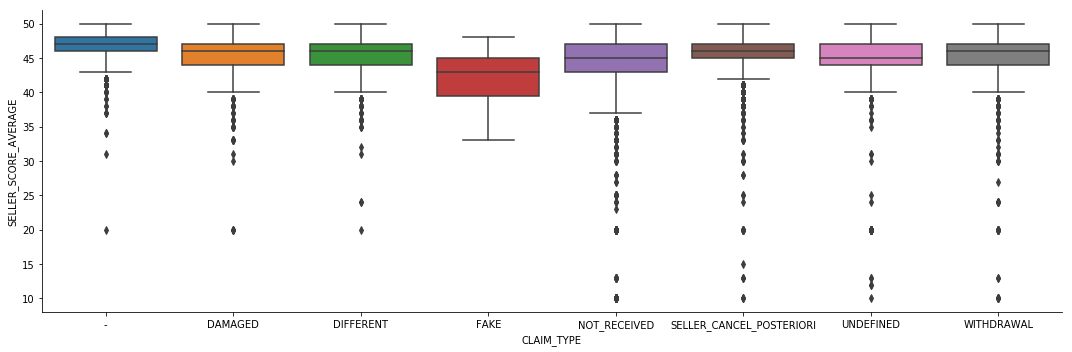

In [11]:
g = sns.catplot(data=missing_data, y='SELLER_SCORE_AVERAGE', x='CLAIM_TYPE', order=claim_order, kind="box", height=5, aspect=3);

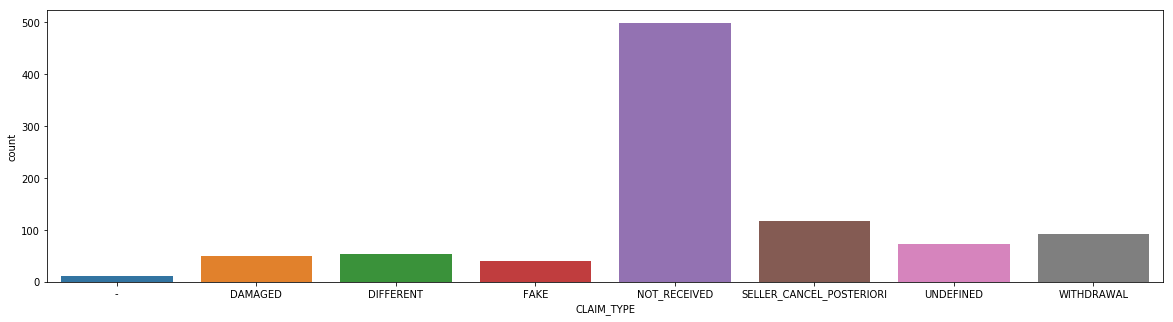

In [12]:
# Outliers for SELLER_SCORE_AVERAGE < 40
d1=missing_data[(missing_data['SELLER_SCORE_AVERAGE']<40)].copy()
plt.figure(figsize=(20,5))
sns.countplot(d1['CLAIM_TYPE'], order=claim_order);

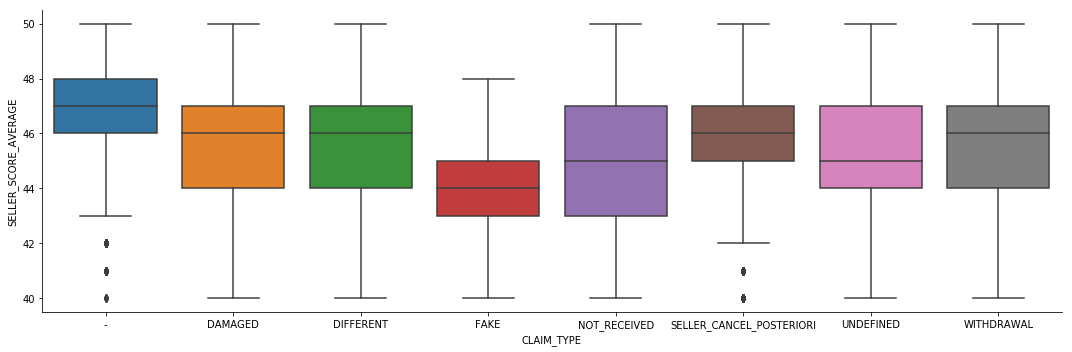

In [13]:
# After removal of SELLER_SCORE_AVERAGE < 40
missing_data = missing_data.drop(missing_data[missing_data['SELLER_SCORE_AVERAGE']<40].index)
g = sns.catplot(data=missing_data, y='SELLER_SCORE_AVERAGE', x='CLAIM_TYPE', order=claim_order, kind="box", height=5, aspect=3);

# Validation

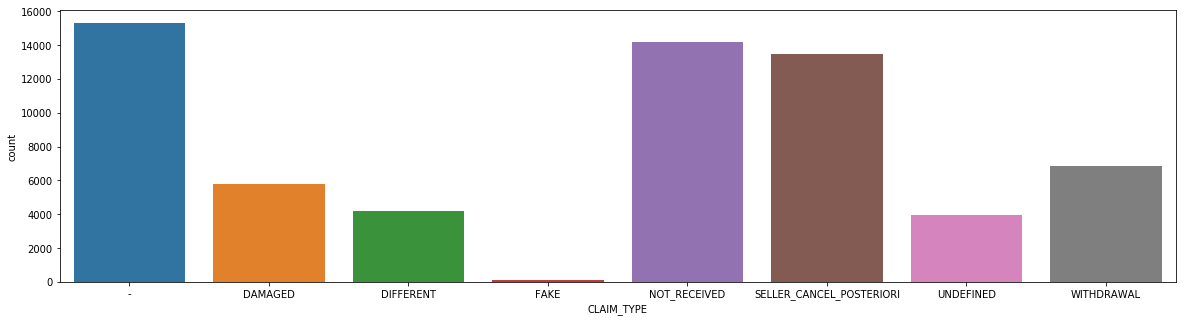

In [14]:
# The final dataset is almost the same as the original before filtering
plt.figure(figsize=(20,5))
sns.countplot(missing_data['CLAIM_TYPE'], order=claim_order);

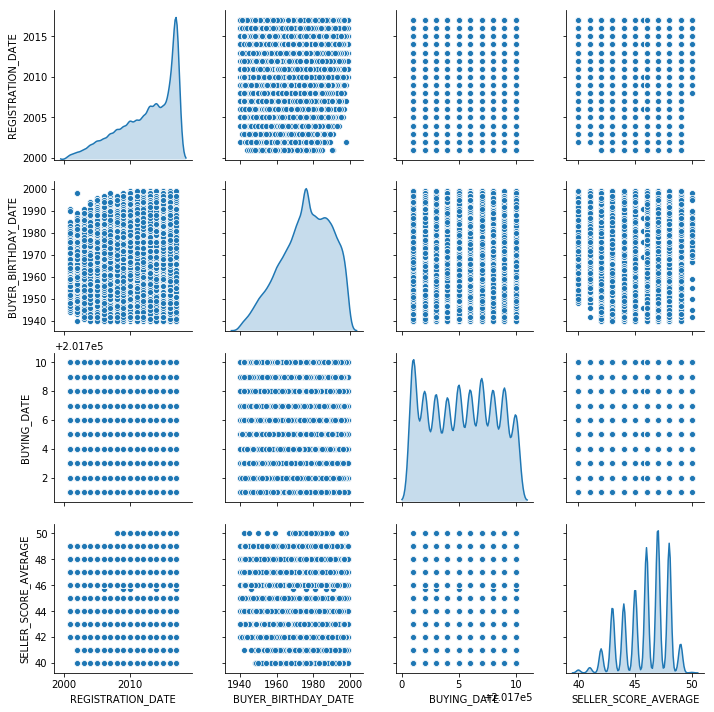

In [15]:
numerical_features = missing_data.get(['REGISTRATION_DATE','BUYER_BIRTHDAY_DATE','BUYING_DATE','SELLER_SCORE_AVERAGE','CLAIM_TYPE']).copy()
sns.pairplot(numerical_features, diag_kind="kde");

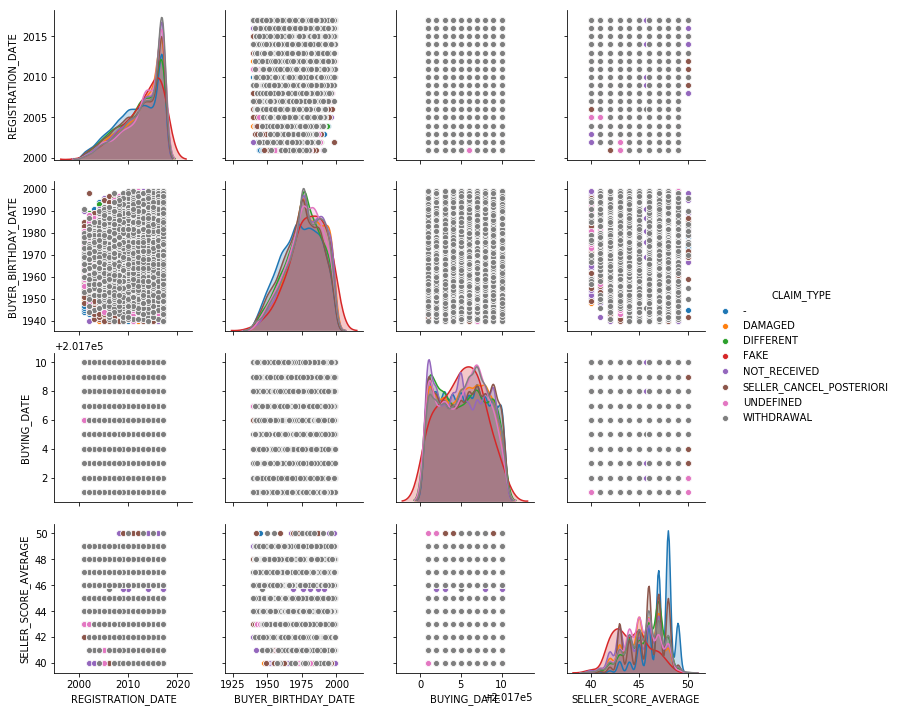

In [16]:
sns.pairplot(numerical_features, hue="CLAIM_TYPE", hue_order=claim_order);